In [1]:
base_path = '/home/u5169119/PatchCL-MedSeg-jiyu'
dataset_path = '/home/u5169119/dataset/0_data_dataset_voc_950_kidney'
output_dir = base_path + '/dataset/splits/kidney'
model_path = base_path +'/best_contrast.pth'
voc_mask_color_map = [
    [0, 0, 0], #_background
    [128, 0, 0] #kidney
]

In [2]:
import os
import sys
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp
import math
import time
from torch.utils.data import DataLoader
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

sys.path.append(base_path)

from utils.transform import Transform
from utils.stochastic_approx import StochasticApprox
from utils.model import Network
from utils.datasets_PASCAL import PascalVOCDataset
from utils.queues import Embedding_Queues
from utils.CELOSS import CE_loss
from utils.patch_utils import _get_patches
from utils.aug_utils import batch_augment
from utils.get_embds import get_embeddings
from utils.const_reg import consistency_cost
from utils.plg_loss import PCGJCL
from utils.torch_poly_lr_decay import PolynomialLRDecay
from utils.loss_file import save_loss

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
contrastive_batch_size = 64
img_size = 512
batch_size = 8
num_classes = 2
transform = Transform(img_size, num_classes)
embd_queues = Embedding_Queues(num_classes)
stochastic_approx = StochasticApprox(num_classes,0.5,0.8)
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.8/dist-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


In [4]:
val_dataset = PascalVOCDataset(txt_file=output_dir + "/val.txt", image_size=img_size, root_dir=dataset_path, labeled=True, colormap=voc_mask_color_map)

val_loader = DataLoader(val_dataset, batch_size=batch_size)
print('number of val_dataset: ', len(val_dataset))

number of val_dataset:  95


In [5]:
# 加載整個模型對象
model = torch.load('./best_contrast.pth')
model.to(dev)
model.eval()

DataParallel(
  (module): Network(
    (seg_model): DeepLabV3Plus(
      (encoder): ResNetEncoder(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, a

In [6]:
def compute_iou(pred, target, num_classes=2):
    ious = []
    pred = pred.view(-1)
    target = target.view(-1)
    
    for cls in range(num_classes):
        pred_inds = (pred == cls)
        target_inds = (target == cls)
        intersection = (pred_inds[target_inds]).long().sum().item()
        union = pred_inds.long().sum().item() + target_inds.long().sum().item() - intersection
        if union == 0:
            ious.append(float('nan'))  # 如果分母為零，將 IoU 設為 NaN
        else:
            ious.append(intersection / union)
    return np.array(ious)

In [16]:
for images, masks in val_loader:
    break   

Channel 1 pixel counts: {0.0: 25393, 1.0: 236751}
Original masks shape:  torch.Size([8, 512, 512])
Multi-channel masks shape:  torch.Size([8, 2, 512, 512])
image shape:  (3, 512, 512)
Image min/max values: 0 255
image.transpose(1, 2, 0) shape:  (3, 512, 512)


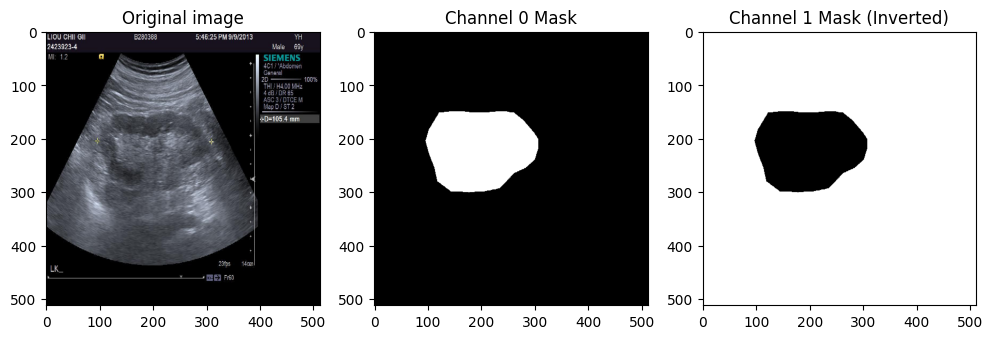

In [19]:
import cv2

# 創建一個新的形狀為 [8, 2, 256, 256] 的張量
multi_channel_masks = torch.zeros((masks.size(0), 2, masks.size(1), masks.size(2)), dtype=torch.float32)

# 將單通道遮罩轉換為多通道遮罩
multi_channel_masks[:, 0, :, :] = masks.float()  # 原始遮罩
multi_channel_masks[:, 1, :, :] = 1 - masks.float()  # 反轉遮罩

imgs_np = multi_channel_masks[0, 1].numpy()
unique, counts = np.unique(imgs_np, return_counts=True)
pixel_counts = dict(zip(unique, counts))
print("Channel 1 pixel counts:", pixel_counts)
print("Original masks shape: ", masks.shape)
print("Multi-channel masks shape: ", multi_channel_masks.shape)

image = images[0].numpy().astype(np.uint8)
print('image shape: ', image.shape)

print("Image min/max values:", image.min(), image.max())
transpose_image = image.transpose(1, 2, 0)       
print('image.transpose(1, 2, 0) shape: ', image.shape)

# 顯示原圖和多通道遮罩
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(transpose_image)
plt.title("Original image")
plt.subplot(1, 3, 2)
plt.imshow(multi_channel_masks[0, 0].numpy(), cmap='gray')
plt.title("Channel 0 Mask")
plt.subplot(1, 3, 3)
plt.imshow(multi_channel_masks[0, 1].numpy(), cmap='gray')
plt.title("Channel 1 Mask (Inverted)")
plt.show()

In [21]:
images, masks = images.to(dev), multi_channel_masks.to(dev)
model.module.contrast=False
out = model(images) 

In [22]:
print("images shape: ", images.shape)
print("masks shape: ", masks.shape)
print("out shape: ", out.shape)

images shape:  torch.Size([8, 3, 512, 512])
masks shape:  torch.Size([8, 2, 512, 512])
out shape:  torch.Size([8, 2, 512, 512])


Output Channel 0 - min: -14.168312 max: 2.8987107 mean: -3.5732086
Output Channel 1 - min: -2.7938015 max: 14.268537 mean: 3.966473


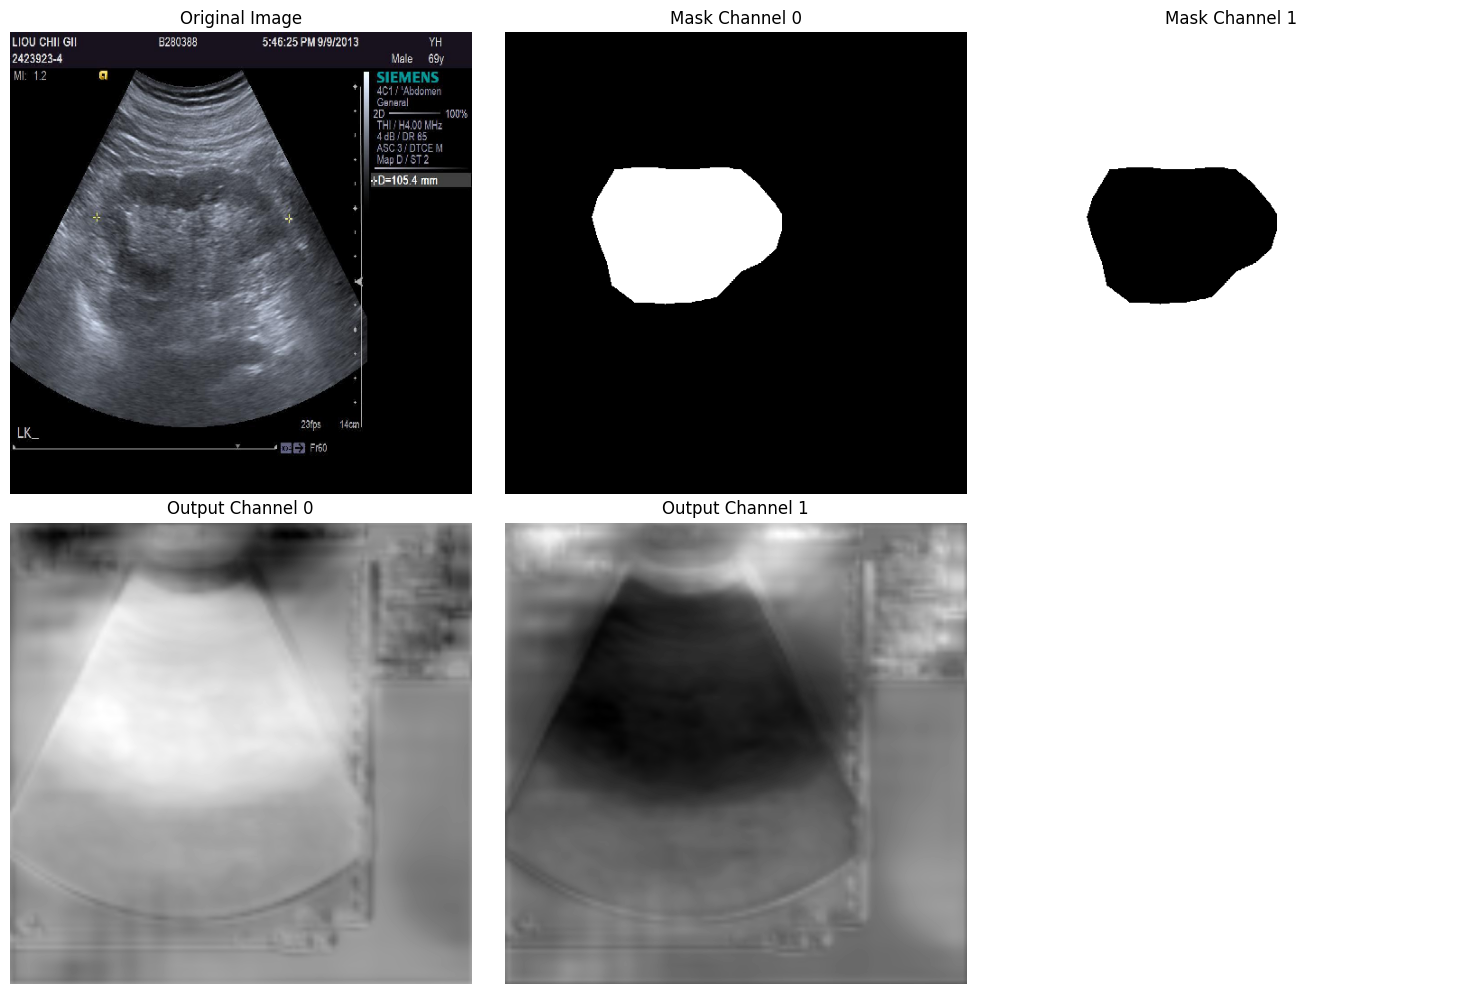

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# 獲取第一張影像和對應的 masks 及 outputs
first_img = images[0].cpu().numpy().transpose(1, 2, 0)
first_mask_channel_0 = masks[0, 0].cpu().numpy()
first_mask_channel_1 = masks[0, 1].cpu().numpy()
first_out_channel_0 = out[0, 0].detach().cpu().numpy()
first_out_channel_1 = out[0, 1].detach().cpu().numpy()

# 打印輸出數據的統計信息
print("Output Channel 0 - min:", first_out_channel_0.min(), "max:", first_out_channel_0.max(), "mean:", first_out_channel_0.mean())
print("Output Channel 1 - min:", first_out_channel_1.min(), "max:", first_out_channel_1.max(), "mean:", first_out_channel_1.mean())

# 檢查並調整影像範圍
if first_img.max() > 1:
    first_img = first_img / 255.0

# 檢查並調整輸出範圍
first_out_channel_0 = (first_out_channel_0 - first_out_channel_0.min()) / (first_out_channel_0.max() - first_out_channel_0.min())
first_out_channel_1 = (first_out_channel_1 - first_out_channel_1.min()) / (first_out_channel_1.max() - first_out_channel_1.min())

# 設置圖形大小
plt.figure(figsize=(15, 10))

# 原始影像
plt.subplot(2, 3, 1)
plt.imshow(first_img)
plt.title('Original Image')
plt.axis('off')

# Mask Channel 0
plt.subplot(2, 3, 2)
plt.imshow(first_mask_channel_0, cmap='gray')
plt.title('Mask Channel 0')
plt.axis('off')

# Mask Channel 1
plt.subplot(2, 3, 3)
plt.imshow(first_mask_channel_1, cmap='gray')
plt.title('Mask Channel 1')
plt.axis('off')

# Output Channel 0
plt.subplot(2, 3, 4)
plt.imshow(first_out_channel_0, cmap='gray')
plt.title('Output Channel 0')
plt.axis('off')

# Output Channel 1
plt.subplot(2, 3, 5)
plt.imshow(first_out_channel_1, cmap='gray')
plt.title('Output Channel 1')
plt.axis('off')

# 顯示圖像
plt.tight_layout()
plt.show()